In [16]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import copy
import pickle
import io

from hydra import compose, initialize
import hydra

from simulators.turin import Turin

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="configs", version_base=None)
cfg = compose(config_name="train")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
turin = Turin()

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    'font.family' : 'times',
    'font.size' : 14.0,
    'lines.linewidth' : 2,
    'lines.antialiased' : True,
    'axes.facecolor': 'fdfdfd',
    'axes.edgecolor': '777777',
    'axes.linewidth' : 1,
    'axes.titlesize' : 'medium',
    'axes.labelsize' : 'medium',
    'axes.axisbelow' : True,
    'xtick.major.size'     : 0,      # major tick size in points
    'xtick.minor.size'     : 0,      # minor tick size in points
    'xtick.major.pad'      : 6,      # distance to major tick label in points
    'xtick.minor.pad'      : 6,      # distance to the minor tick label in points
    'xtick.color'          : '333333', # color of the tick labels
    'xtick.labelsize'      : 'medium', # fontsize of the tick labels
    'xtick.direction'      : 'in',     # direction: in or out
    'ytick.major.size'     : 0,      # major tick size in points
    'ytick.minor.size'     : 0,      # minor tick size in points
    'ytick.major.pad'      : 6,      # distance to major tick label in points
    'ytick.minor.pad'      : 6,      # distance to the minor tick label in points
    'ytick.color'          : '333333', # color of the tick labels
    'ytick.labelsize'      : 'medium', # fontsize of the tick labels
    'ytick.direction'      : 'in',     # direction: in or out
    'axes.grid' : False,
    'grid.alpha' : 0.3,
    'grid.linewidth' : 1,
    'legend.fancybox' : True,
    'legend.fontsize' : 'Small',
    'figure.figsize' : (2.5, 2.5),
    'figure.facecolor' : '1.0',
    'figure.edgecolor' : '0.5',
    'hatch.linewidth' : 0.1,
    'text.usetex' : True
    })

color_map = {'green': '#009E60', 'orange': '#C04000',
              'blue': '#00416A', 'black':'#3A3B3C',
              'purple': '#843B62', 'red': '#C41E3A'}


plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

In [7]:
i=0
checkpoint_path = f"sims/turin/mixture/{i+1}/ckpt.tar"
checkpoint = torch.load(checkpoint_path, map_location='cpu')

posterior_npe = checkpoint["posterior_npe"]
posterior_canpe = checkpoint["posterior_canpe"]

posterior_samples_npe = checkpoint["posterior_samples_npe"]
posterior_samples_canpe = checkpoint["posterior_samples_canpe"]

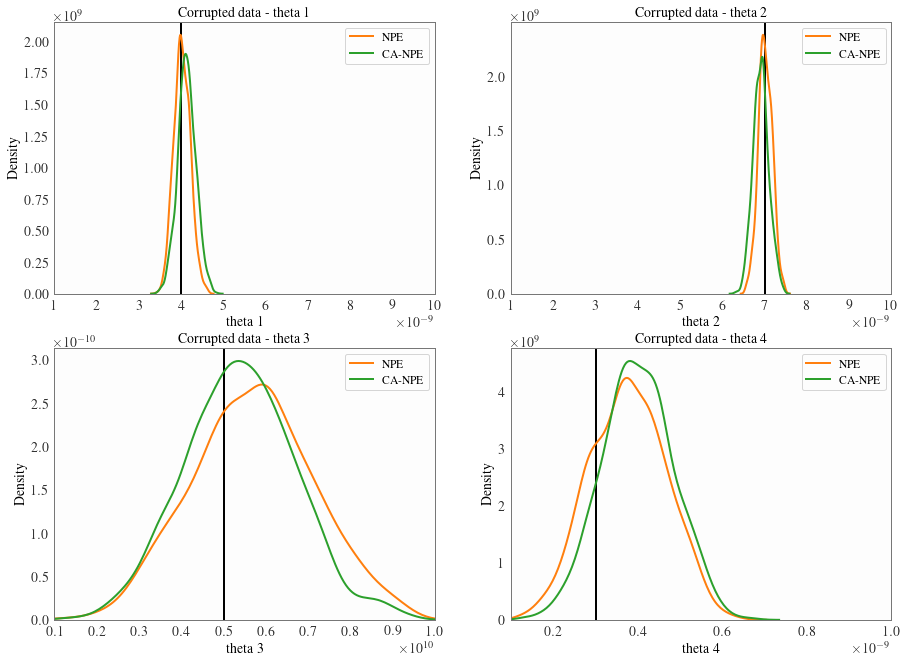

In [21]:
prior = [[1e-9, 1e-8], [1e-9, 1e-8], [1e9, 1e10], [1e-10, 1e-9]]
plt.figure(figsize=[15,11])
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.axvline(x=turin.theta_true[i],ls="-",c="black")
    sns.kdeplot(posterior_samples_npe[:,i], color = "C1", linewidth = 2, linestyle = "solid", label = "NPE ")
    sns.kdeplot(posterior_samples_canpe[:,i], color = "C2", linewidth = 2, linestyle = "solid", label = "CA-NPE")
    plt.legend()
    plt.xlim(prior[i][0], prior[i][1])
    plt.title(f"Corrupted data - theta {i+1}")
    plt.xlabel(f"theta {i+1}")
    plt.ylabel("Density")
    
plt.show()